---
author: "Ricardo Semião e Castro"
warning: false
message: false
format:
  pdf:
    toc: true
    toc-depth: 3
    number-sections: false
    include-in-header:
      text: |
        \usepackage{sectsty}
        \usepackage{etoolbox}
        \patchcmd{\tableofcontents}{\thispagestyle{plain}}{\thispagestyle{plain}\clearpage}{}{}
        \subsectionfont{\clearpage}
---

# Problem Set 2

## Setup

The files from this problem set can be found in [github.com/ricardo-semiao/task-masters -> quant-macro](https://github.com/ricardo-semiao/task-masters/tree/main/quant-macro).

Importing required libraries:

In [69]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import optimize

In this problem set, we will deal with a RBC model with capital adjustment costs.

## 1.1 Deterministic equilibrium

### a)

Firm's problem is to maximize profits:

$$\max \pi_T = Y_tp_T - k_tr_t = A_tk_t^\alpha - k_tr_t$$

Where I normalized $p = 1$.

From the FOC we get the equations for $w$ and $r$:

$$ r_t = \alpha A k_t^{\alpha-1} ~~~~ (1)$$

$$  w_t = A k_t^\alpha - r_t k_t = (1 - \alpha) A k_t^\alpha ~~~~ (2)$$

The consumers problem is to maximize utility subject to 1.2 and 1.3. We know that Inada is valid, and that 1.2 will be binding. Then:

$$ \max_{(c_t, k_{t+1})_t} \sum_{t=0}^\infty \beta^t \left( \frac{c_t^{1-\sigma}}{1-\sigma} \right) ~s.t.~ (1.2),~ (1.3) $$

From the FOC, we get the Euler equation:

$$ c_t^{-\sigma}\left(1 + \phi(\frac{k_{t+1}}{k_t} - 1)\right) = \beta c_{t+1}^{-\sigma}\left(\alpha Ak^{\alpha - 1}_{t+1} + 1 - \delta  - \frac{\phi}{2}(1 - \frac{k^2_{t+2}}{k^2_{t+1}})\right)$$

Where we can substitute the restrictions to find a system of equations that depends on $k_t$, $k_{t+1}$ and $k_{t+2}$. Call this un-derived equation, equation $(3)$.

The last equations that are needed are the market clearing ones:

- The goods are cleared: $c_t + i_t = Y_t = Ak_t^\alpha ~~~~ (4)$.
- The income is cleared: $r_tk_t + w_t = Ak_t^\alpha ~~~~ (5)$.

Lastly, we need an initial condition for $k_0$.

With all this in hand, we have equations (1) - (5), and five relevant variables: $r_t$, $w_t$, $k_t$, $k_{t+1}$ and $k_{t+2}$.

The central planner's problem is to maximize the sum of utilities subject to the resource constraint. Such constraint can be directly substituted in the utility function, and the problem becomes:

$$ \max_{k_t} \sum_{t=0}^\infty \beta^t \left( \frac{\left(Ak_t^\alpha + (1 - \delta)k_t - k_{t+1} - \frac{\phi}{2}(\frac{k_{t+1}}{k_t} - 1)^2\right)^{1-\sigma}}{1-\sigma} \right)$$

As we have perfect competition, one could argue that these would yield the same result. But, this might not be the case, since we have an important friction: the capital adjustment costs.

### b)

In the steady state, we have that $k_{t+1} = k_t = k_*$. The Euler equation becomes:

$$ (Ak^\alpha_* - \delta_*)^{-\sigma} = \beta(Ak^\alpha_* - \delta k_*)^{-\sigma}(\alpha Ak^{\alpha-1}_* + 1 - \delta) $$

Solving for $k_*$, we get:

$$ k_* = \left( \frac{\alpha \beta A}{1 - \beta(1 - \delta)} \right)^{\frac{1}{1-\alpha}} $$

Substituting that in the relevant equations for every variable, we get:

$$ r_* = \frac{1}{\beta} - (1 - \delta) $$

$$ w_* = A(1-\alpha)\left(\frac{\alpha \beta A}{1 - \beta(1 - \delta)}\right)^{\frac{1}{1-\alpha}} $$

$$ Y_* = A\left(\frac{\alpha \beta A}{1 - \beta(1 - \delta)}\right)^{\frac{\alpha}{1-\alpha}} $$

### c)

We start by defining the parameters in a dictionary:

In [70]:
q1_params = {
    'beta': 0.98,
    'sigma': 2.00,
    'A': 1.00,
    'alpha': 1/3,
    'delta': 0.05,
    'phi': 5.00
}

Then, we use the formulas from the last items to get the steady state values:

In [71]:
def get_ss_analytical(beta, sigma, A, alpha, delta, phi):
    k_ss = ((beta * alpha * A) / (1 - beta * (1 - delta))) ** (1 / (1 - alpha))
    return {
        'k_ss': k_ss,
        'i_ss': delta * k_ss,
        'r_ss': alpha * A * k_ss ** (alpha - 1),
        'c_ss': A * k_ss ** alpha - delta * k_ss,
        'y_ss': k_ss ** alpha,
        's_ss': delta * k_ss / (k_ss ** alpha)
    }

q1_ss = get_ss_analytical(**q1_params)
{key: round(value, 3) for key, value in q1_ss.items()}

{'k_ss': 10.301,
 'i_ss': 0.515,
 'r_ss': 0.07,
 'c_ss': 1.661,
 'y_ss': 2.176,
 's_ss': 0.237}

Now, we know that our goal is to build the capital path. The consumer decision follows the FOC, so we will find $k_{t+2}$ using $k_{t+1}$ and $k_t$, while following the FOC.

We factorize the problem into a function for the consumption and one for the FOC. Then, we create the function that $k_{t+2}$, and the objective function, that applies it recursively to find the whole path.

In [72]:
def consumption(k1, k2, beta, sigma, A, alpha, delta, phi):
    c = A * k1**alpha + (1 - delta) * k1 - k2 - phi / 2 * (k2 / k1 - 1)**2 * k1
    return max(c, 1e-9)

def foc(k0, k1, k2, sigma, A, alpha, delta, phi, beta):
    k0, k1, k2 = (max(x, 1e-9) for x in (k0, k1, k2))
    c1, c2 = (consumption(ki, kj, **q1_params) for ki, kj in [(k0,k1), (k1,k2)])
    return beta * c1**sigma * (alpha * A * k0**(alpha - 1) +\
        (1 - delta) + (phi / 2) * (k2**2 / k1**2 - 1)) -\
        (1 + phi * (k1 / k0 - 1)) * c2**sigma

In [73]:
def k2(k0, k1, sigma, A, alpha, delta, phi, beta):
    def obj(k2): return foc(k0, k1, k2, sigma, A, alpha, delta, phi, beta)
    k2 = optimize.fsolve(obj, float(k1))[0]
    return max(k2, 1e-9)

def find_path(k0, k1, sigma, A, alpha, delta, phi, beta, T = 100):
    path = np.empty(T)
    path[0:2] = [k0, k1]

    for t in range(2, T):
        path[t] = k2(path[t-2], path[t-1], **q1_params)

    return path

We can now find the capital path with:

`find_path(q1_ss['k_ss']/2, q1_ss['k_ss'], **q1_params)`

Now, we want to use the Bisection numeric method. Lets start with the function created in the last Problem Set, recall its main part:

```python
for iter in range(1, max_iter + 1):
    x = (a + b) / 2
    residual = fun(x, **kwargs)

    if abs(residual) < tol:
        return {"value": x, "iterations": iter}
```

We can see some problems:

- Now, our objective function recieves two inputs, $k_{t+1}$ and $k_t$.
- Our desired value is a vector (the path), not a scalar.
- The tolerance comparison must be made with the last element of the path, not with a scalar.

Thus, we change:

- `residual = fun(x, **kwargs)` -> `path[-1] - guess[1]`.
- `{"value": x, "iterations": iter}` -> `{"value": path, "iterations": iter}`.

And we get the updated function:

In [89]:
def solve_bisection(
        fun, guess,
        tol = 1e-6, max_iter = 300, quiet = True,
        **kwargs
    ):
    a, b = guess

    for iter in range(1, max_iter + 1):
        x = (a + b) / 2
        path = fun(a, x, **kwargs)
        residual = path[-1] - guess[1]

        if abs(residual) < tol:
            return {"value": path, "iterations": iter}

        if residual > 0:
            b = x
        else:
            a = x

    if not quiet: print(f"Bisection method did not converge after {max_iter} iterations.")
    return {"value": path, "iterations": None} 

But, our goal is to analyze all the paths, that we can find once we get the capital path. So, lets create and plots the paths of the other variables, given the capital path.

In [86]:
def path_to_vars(kp, sigma, alpha, beta, delta, phi, A):
    yp = A * (kp[:-1])**alpha
    ip = kp[1:] - (1 - delta)*kp[:-1] + (phi/2)*kp[:-1]*((kp[1:])/(kp[:-1]) - 1)**2
    cp = (kp[:-1])**alpha - (kp[1:] - (1 - delta)*kp[:-1] + (phi/2)*kp[:-1]*((kp[1:])/(kp[:-1]) - 1)**2)
    rp = alpha * ((kp[:-1])**(alpha - 1))
    wp = (1-alpha) * kp[:-1]**alpha
    return {'kp': kp, 'yp': yp, 'ip': ip, 'cp': cp, 'rp': rp, 'wp': wp}

def plot_paths(paths):
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    
    axs[0, 0].plot(paths['kp'], linestyle='-', color='b')
    axs[0, 0].set_title('Capital Path (kp)')

    axs[0, 1].plot(paths['yp'], linestyle='-', color='g')
    axs[0, 1].set_title('Output Path (yp)')

    axs[0, 2].plot(paths['ip'], linestyle='-', color='r')
    axs[0, 2].set_title('Investment Path (ip)')

    axs[1, 0].plot(paths['cp'], linestyle='-', color='c')
    axs[1, 0].set_title('Consumption Path (cp)')

    axs[1, 1].plot(paths['rp'], linestyle='-', color='m')
    axs[1, 1].set_title('Interest Rate Path (rp)')

    axs[1, 2].plot(paths['wp'], linestyle='-', color='y')
    axs[1, 2].set_title('Wage Path (wp)')

    for ax in axs.flat:
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')

    plt.tight_layout()
    plt.show()

Now, finally, we can plot the paths:

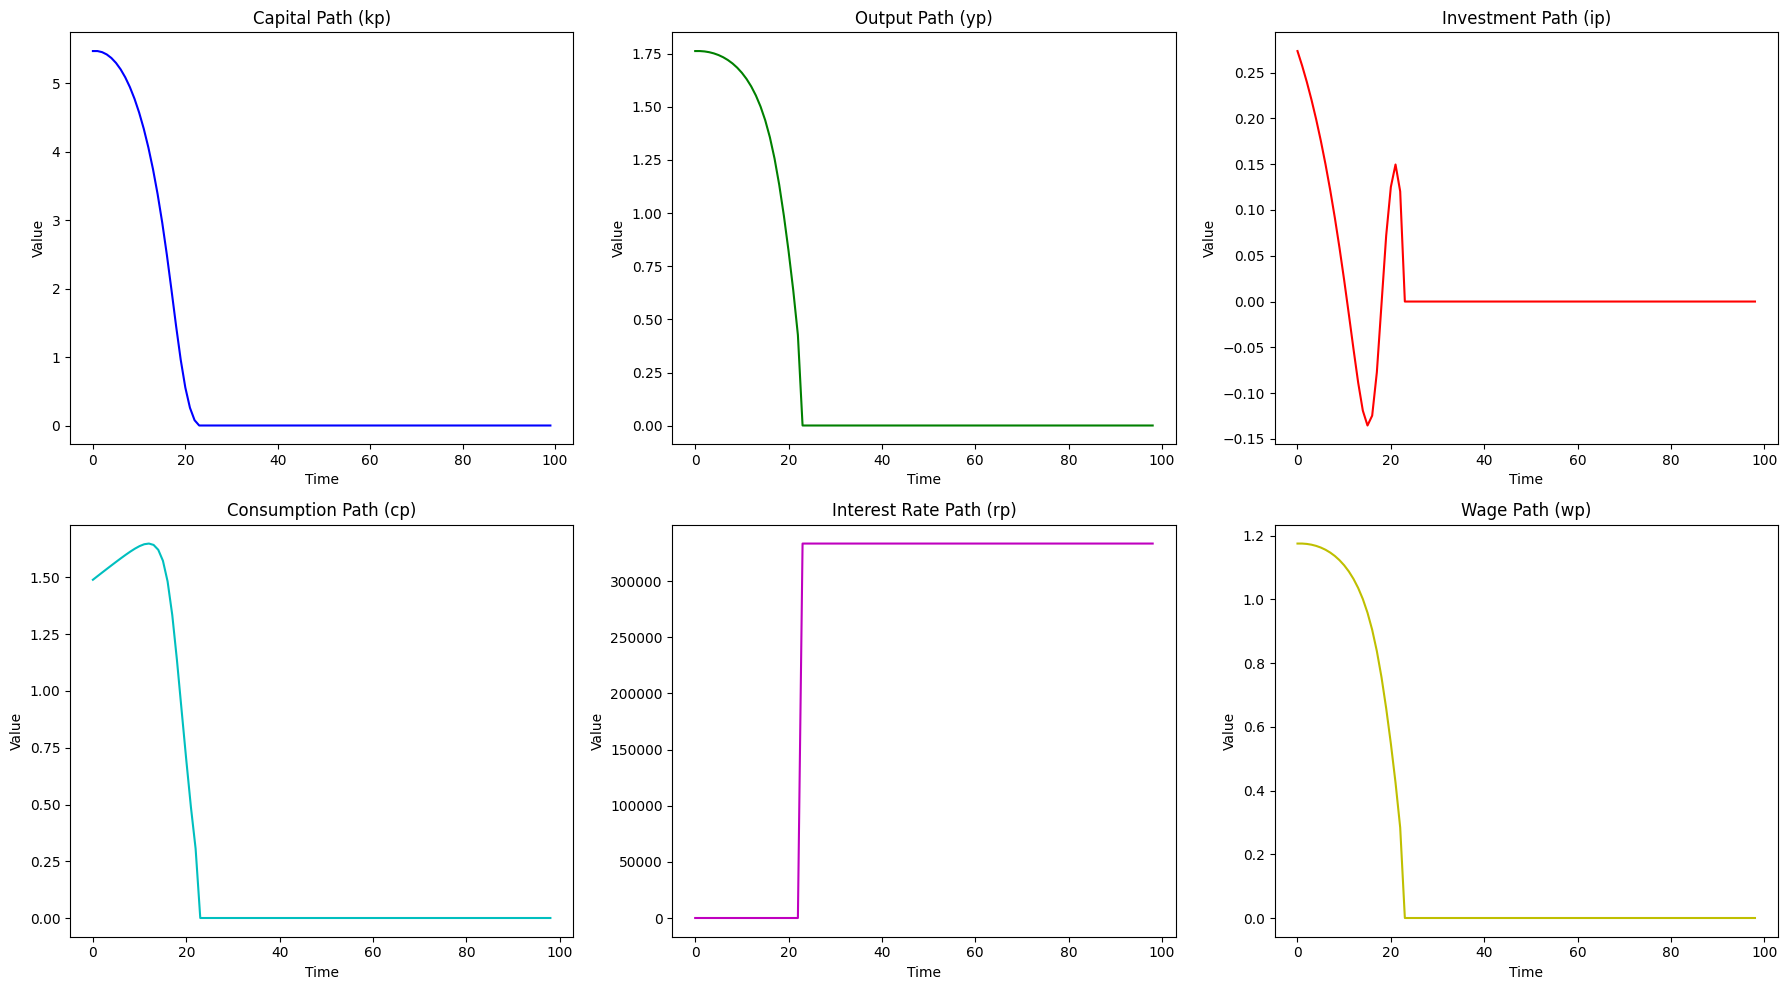

In [87]:
kp = solve_bisection(find_path, (q1_ss['k_ss']/2, q1_ss['k_ss']), **q1_params)
plot_paths(path_to_vars(kp['value'], **q1_params))

We got some clunky results, which came from the approximation we made in the function `k2`: `max(k2, 1e-9)`. This was to avoid errors, but lead to the leaps seen in the graphs, which probably aren't the intended result.

We can now add the comparison with $\phi = 0$:

C:\Users\ricar\AppData\Local\Temp\ipykernel_9584\3299217678.py:3: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  k2 = optimize.fsolve(obj, float(k1))[0]


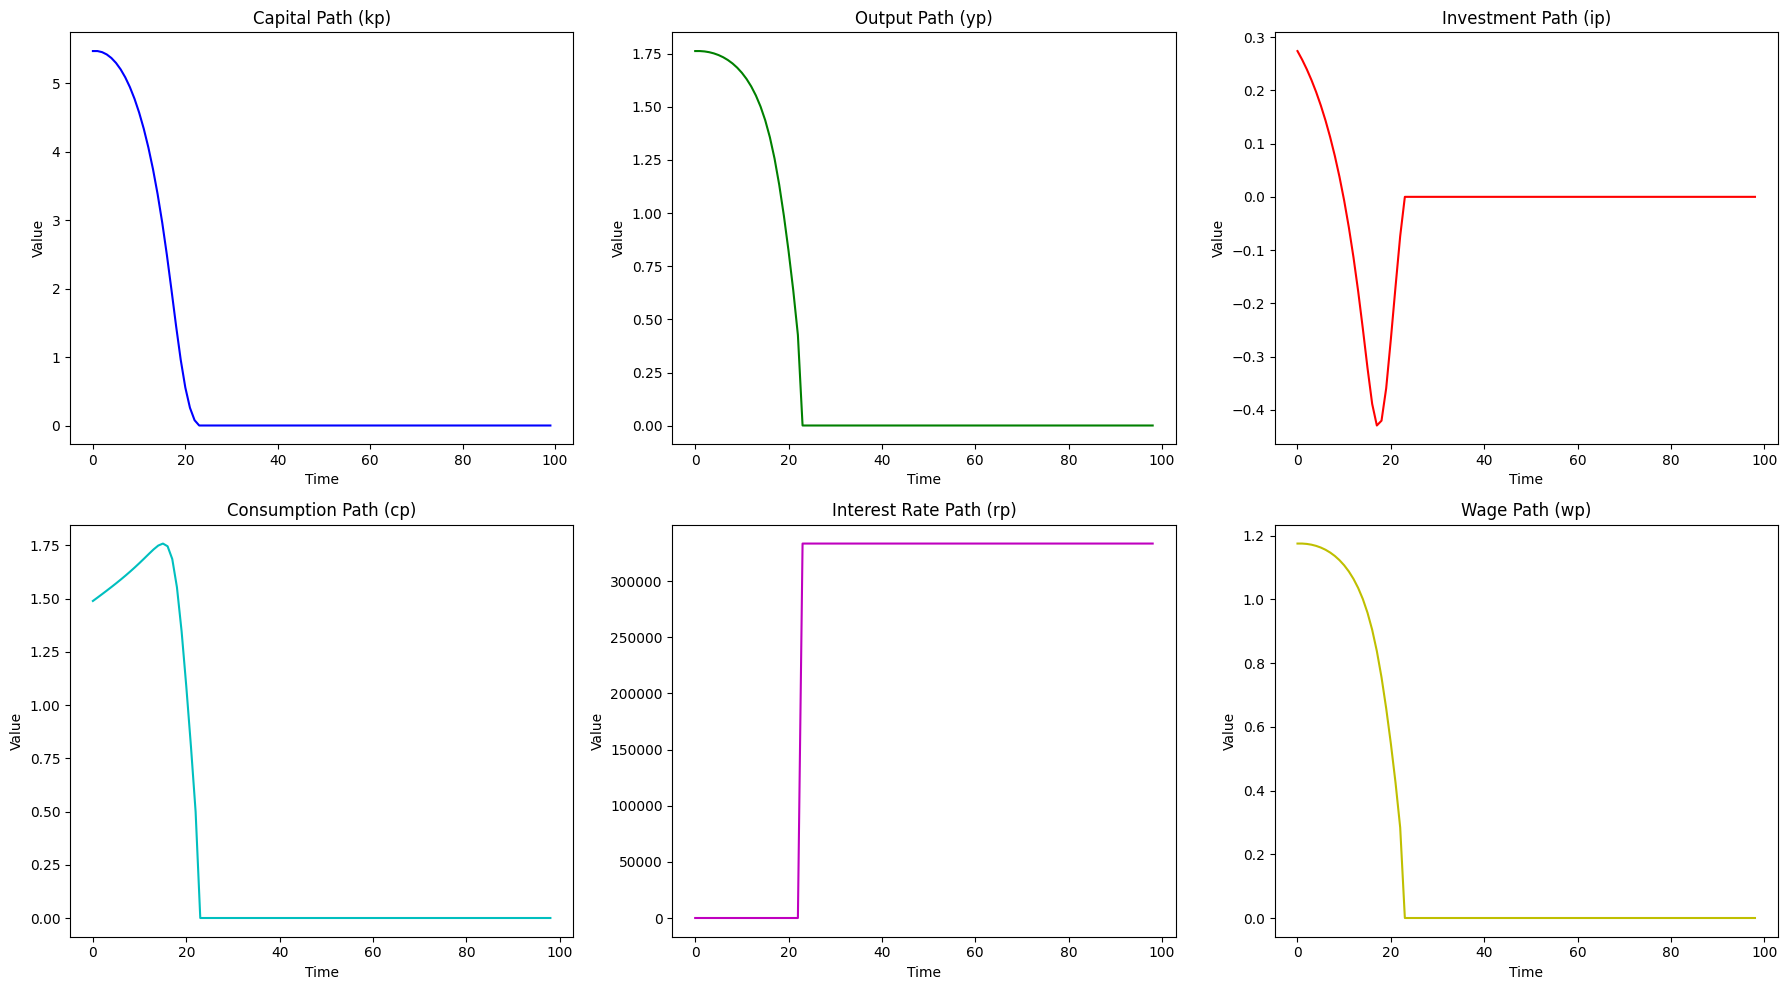

In [92]:
q1_params2 = q1_params.copy()
q1_params2['phi'] = 0

kp2 = solve_bisection(find_path, (q1_ss['k_ss']/2, q1_ss['k_ss']), **q1_params2)

plot_paths(path_to_vars(kp['value'], **q1_params))
plot_paths(path_to_vars(kp2['value'], **q1_params2))

Comparing with the previous results, we can see that the convergence is faster, which is expected, since the adjustment costs make the agents take "slower" decisions, that is, adjust slower, as to pay less costs. Thus, when they disappear, the agents can move to the optimal faster.

### d)

The main part of the problem is defining a function to define the system of equations, which will then be solved with fsolve.

Its main logic is to set the initial (and final) conditions, and then iterate over the FOC defined earlier.

In [97]:
def create_system(kp, k0, k_ss, sigma, alpha, delta, phi, A, beta, t = 100):
    eqs = np.zeros(T)
    eqs[0] = foc(k0, kp[0], kp[1], sigma, A, alpha, delta, phi, beta)
    eqs[T-1] = foc(kp[-2], kp[-1], k_ss, sigma, A, alpha, delta, phi, beta)

    for t in range(1, T-1):
        eqs[t] = foc(kp[t-1], kp[t], kp[t+1], sigma, A, alpha, delta, phi, beta)

    return eqs

Now, we can create the initial guess with the given boundaries, and solve the system.

In [ ]:
guess = np.linspace(q1_ss['k_ss']/2, q1_ss['k_ss'], 100)

k_solution = optimize.fsolve(create_system, guess,
    args = (q1_ss['k_ss']/2, q1_ss['k_ss'], *q1_params)
)

### e)

The value function is:

$$ V(k) = \max_{c, k'} \left( u(c) + \beta V(k')\right) ~s.t.~ (1.2),~ (1.3)$$

We can substitute the constraints to remove $c$ from the problem:

$$ V(k) = \max_{k'} \left(u\left(Ak^\alpha + (1 - \delta)k - 0.5\phi(\frac{k'}{k}-1)^2k - k'\right) + \beta V(k')\right)$$